# Scikit-learn Pipelines for Geotechnical ML

In this notebook, we’ll learn how to build robust scikit-learn Pipelines for geotechnical datasets. We’ll focus on:
- Why pipelines matter (avoid data leakage, reproducibility, tidy code)
- Combining preprocessing and modeling with `Pipeline` and `ColumnTransformer`
- Evaluating models correctly with cross-validation
- Visualizing results
- Using both a synthetic geotechnical-like dataset and the project’s CPT dataset (`data/raw/CPT_PremstallerGeotechnik_revised.csv`)

References:
- Scikit-learn Pipeline: https://scikit-learn.org/stable/modules/compose.html#pipeline
- ColumnTransformer: https://scikit-learn.org/stable/modules/compose.html#columntransformer

In [1]:
# Imports (must be at the very top to satisfy ruff E402)
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Setup
warnings.filterwarnings("ignore")
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (8, 5)
np.random.seed(42)

## Why Pipelines?

- They bundle preprocessing + model into one object.
- All transformations are fit only on the training folds during CV, preventing leakage.
- Cleaner, reproducible code and easier model deployment.

We’ll illustrate with a small synthetic geotechnical-style dataset: predicting soil behavior category from CPT-like features and a categorical site variable.

In [2]:
# Create a synthetic CPT-like dataset
n = 1000
depth = np.random.uniform(0, 30, size=n)  # meters
qc = np.random.lognormal(mean=1.5, sigma=0.6, size=n) * (
    1 + depth / 40
)  # cone resistance
fs = np.random.lognormal(mean=0.2, sigma=0.4, size=n) * (
    1 + depth / 50
)  # sleeve friction
Rf = 100 * fs / (qc + 1e-6)  # friction ratio (%)
site = np.random.choice(["A", "B", "C"], size=n, p=[0.5, 0.3, 0.2])

# Hidden rule: higher qc and lower Rf more likely coarse soils; deeper -> slightly more overconsolidation-like behavior
prob_coarse = 1 / (
    1 + np.exp(-(0.8 * np.log1p(qc) - 0.6 * np.log1p(Rf) + 0.03 * depth))
)
y = (prob_coarse > np.random.rand(n)).astype(int)  # 1=coarse, 0=fine

df = pd.DataFrame(
    {
        "depth_m": depth,
        "qc_MPa": qc,
        "fs_kPa": fs * 1000,  # convert to kPa for realism
        "Rf_pct": Rf,
        "site": site,
        "target_coarse": y,
    }
)
df.head()

,depth_m,qc_MPa,fs_kPa,Rf_pct,site,target_coarse
0,11.236204,6.386507,852.304506,13.345391,A,1
1,28.521429,3.445470,1855.411188,53.850720,B,1
2,21.959818,8.720925,962.902352,11.041285,A,1
3,17.959755,9.367262,2249.965910,24.019458,A,1
4,4.680559,7.004363,1380.521235,19.709443,A,0


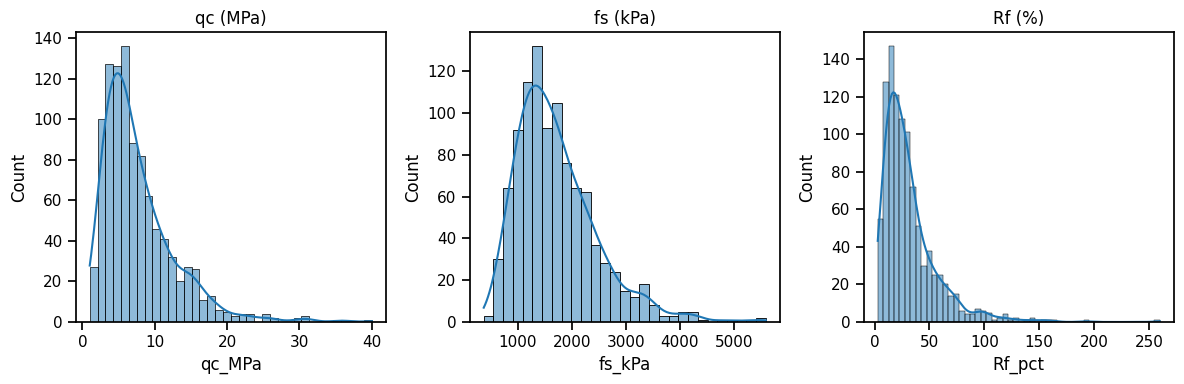

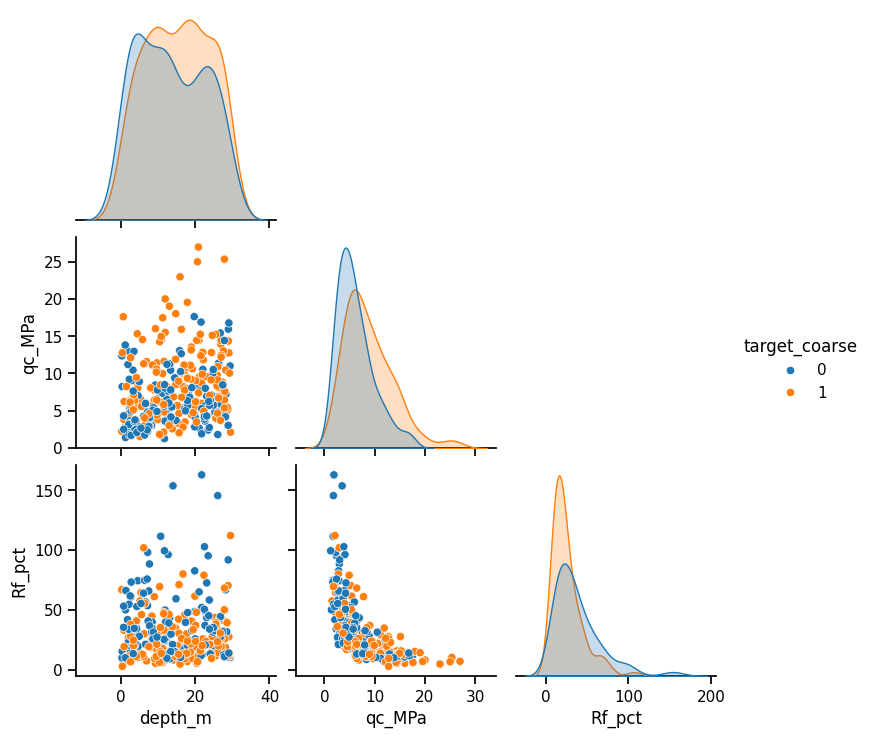

In [3]:
# Quick visualization of distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df["qc_MPa"], kde=True, ax=axes[0])
axes[0].set_title("qc (MPa)")
sns.histplot(df["fs_kPa"], kde=True, ax=axes[1])
axes[1].set_title("fs (kPa)")
sns.histplot(df["Rf_pct"], kde=True, ax=axes[2])
axes[2].set_title("Rf (%)")
plt.tight_layout()
plt.show()

sns.pairplot(
    df.sample(300),
    vars=["depth_m", "qc_MPa", "Rf_pct"],
    hue="target_coarse",
    corner=True,
)
plt.show()

## Demonstrating Data Leakage (what NOT to do)

Below we split into train/test but mistakenly scale using the full dataset before the split. This leaks information from test into train.

In [3]:
# BAD: Fit transformers on full data before split

X = df[["depth_m", "qc_MPa", "fs_kPa", "Rf_pct", "site"]]
y = df["target_coarse"]

# Wrongly impute and scale globally
num_cols = ["depth_m", "qc_MPa", "fs_kPa", "Rf_pct"]
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[num_cols] = scaler.fit_transform(X_scaled[num_cols])  # leakage here!

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=200)
clf.fit(pd.get_dummies(X_train, drop_first=True), y_train)
print("Leaky test score:", clf.score(pd.get_dummies(X_test, drop_first=True), y_test))

Leaky test score: 0.67


## Correct approach with Pipeline and ColumnTransformer

We define preprocessing for numeric and categorical columns and bundle it with a classifier. During cross-validation/train-test, preprocessing is fit only on training folds.

In [4]:
# Build a proper pipeline
numeric_features = ["depth_m", "qc_MPa", "fs_kPa", "Rf_pct"]
categorical_features = ["site"]

numeric_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
    ]
)

model = LogisticRegression(max_iter=200)
pipe = Pipeline(steps=[("preprocess", preprocess), ("clf", model)])

X = df.drop(columns=["target_coarse"])
y = df["target_coarse"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
print("CV accuracy:", scores.round(3))
print("Mean:", scores.mean().round(3), "+/-", scores.std().round(3))

CV accuracy: [0.635 0.64  0.7   0.665 0.6  ]
Mean: 0.648 +/- 0.033


              precision    recall  f1-score   support

           0      0.675     0.559     0.612        93
           1      0.667     0.766     0.713       107

    accuracy                          0.670       200
   macro avg      0.671     0.663     0.662       200
weighted avg      0.671     0.670     0.666       200



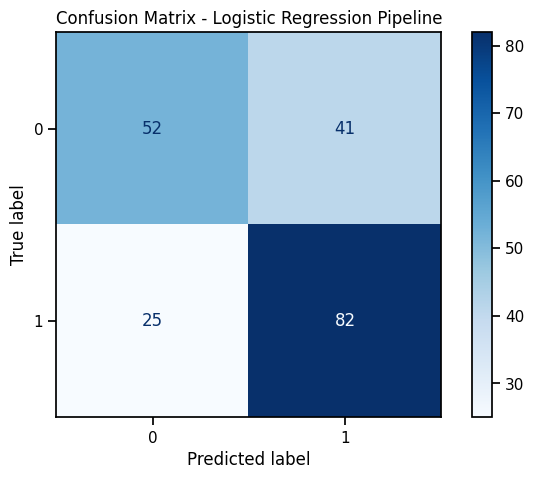

In [6]:
# Train/test split and evaluation with confusion matrix
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression Pipeline")
plt.show()

## Switching models is easy

We can swap the classifier to a RandomForest and reuse the same preprocessing without changes.

RF CV accuracy: [0.57  0.625 0.605 0.58  0.63 ]
Mean: 0.602 +/- 0.024
              precision    recall  f1-score   support

           0      0.549     0.602     0.574        93
           1      0.622     0.570     0.595       107

    accuracy                          0.585       200
   macro avg      0.586     0.586     0.585       200
weighted avg      0.588     0.585     0.585       200

              precision    recall  f1-score   support

           0      0.549     0.602     0.574        93
           1      0.622     0.570     0.595       107

    accuracy                          0.585       200
   macro avg      0.586     0.586     0.585       200
weighted avg      0.588     0.585     0.585       200



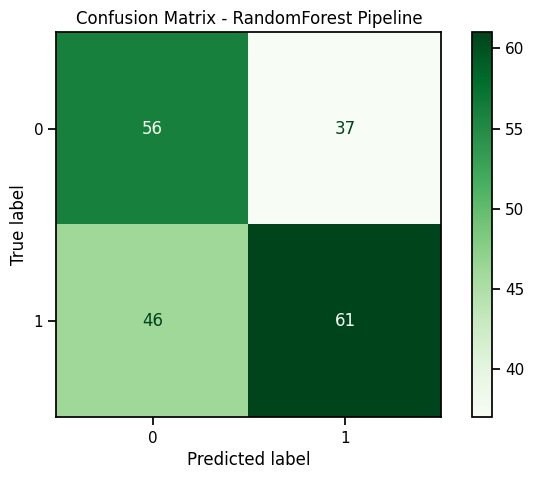

In [5]:
# Swap in a RandomForest
rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42)),
    ]
)
rf_scores = cross_val_score(rf_pipe, X, y, cv=cv, scoring="accuracy")
print("RF CV accuracy:", rf_scores.round(3))
print("Mean:", rf_scores.mean().round(3), "+/-", rf_scores.std().round(3))

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print(classification_report(y_test, y_pred_rf, digits=3))
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap="Greens")
plt.title("Confusion Matrix - RandomForest Pipeline")
plt.show()

## Using the curated CPT dataset (optional)

We’ll load the curated project dataset at `data/model_ready/cpt_dataset_total.csv`, adapt a few column names to align with this notebook’s pipeline, and run the same pipeline. If the file is missing, this section will be skipped gracefully.

Looking for: C:\Users\TFH\git_projects\course-machine-learning-for-geotechnics\data\model_ready\cpt_dataset_total.csv
Loaded curated CPT dataset with shape: (807293, 13)
Curated labels present. Running pipeline...
Loaded curated CPT dataset with shape: (807293, 13)
Curated labels present. Running pipeline...
Curated CV accuracy: [0.81  0.775 0.794]
Curated CV accuracy: [0.81  0.775 0.794]


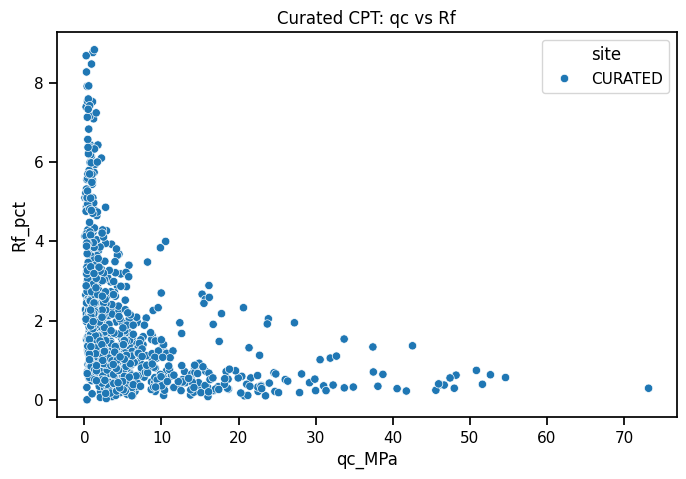

In [6]:
# Optional: run pipeline on curated CPT dataset if present
from pathlib import Path

curated_path = Path("..", "data", "model_ready", "cpt_dataset_total.csv").resolve()
print("Looking for:", curated_path)
if curated_path.exists():
    df_cur = pd.read_csv(curated_path)
    print("Loaded curated CPT dataset with shape:", df_cur.shape)

    # Expected curated columns from project convention
    # Features we want to align to this notebook's pipeline variables
    #   depth_m  <- 'Depth (m)'
    #   qc_MPa   <- 'qc (MPa)'
    #   fs_kPa   <- 'fs (kPa)'
    #   Rf_pct   <- 'Rf (%)'
    #   site     <- constant (single site label)
    # Label (optional): 'Oberhollenzer_classes' (1..7)
    needed = ["Depth (m)", "qc (MPa)", "fs (kPa)", "Rf (%)"]
    if all(col in df_cur.columns for col in needed):
        tmp = pd.DataFrame(
            {
                "depth_m": df_cur["Depth (m)"],
                "qc_MPa": df_cur["qc (MPa)"],
                "fs_kPa": df_cur["fs (kPa)"],
                "Rf_pct": df_cur["Rf (%)"],
            }
        )
        tmp["site"] = "CURATED"

        # If label exists, map 1-3 => coarse (1), 4-7 => fine (0) for a binary demo
        if "Oberhollenzer_classes" in df_cur.columns:
            y_raw = df_cur["Oberhollenzer_classes"]
            if np.issubdtype(y_raw.dtype, np.number):
                y_mapped = (y_raw <= 3).astype(int)
            else:
                # Fallback: try textual mapping if ever string encoded
                y_mapped = (
                    y_raw.astype(str)
                    .str.contains("sand|gravel|coarse", case=False, regex=True)
                    .astype(int)
                )

            X_cur = tmp
            y_cur = y_mapped
            print("Curated labels present. Running pipeline...")
            scores_cur = cross_val_score(pipe, X_cur, y_cur, cv=3, scoring="accuracy")
            print("Curated CV accuracy:", scores_cur.round(3))
        else:
            print(
                "No label column found; skipping supervised training on curated dataset."
            )

        # Quick visualization (subsampled for speed)
        sns.scatterplot(
            data=tmp.sample(min(1000, len(tmp))), x="qc_MPa", y="Rf_pct", hue="site"
        )
        plt.title("Curated CPT: qc vs Rf")
        plt.show()
    else:
        print("Curated dataset is missing required feature columns. Skipping.")
else:
    print("Curated CPT dataset not found; skipping optional section.")

## Key takeaways

- Always wrap preprocessing inside a Pipeline to avoid leakage.
- Use ColumnTransformer to handle mixed numeric/categorical columns.
- Cross-validate the entire pipeline, not just the model.
- Swapping models is trivial once preprocessing is standardized.

## Student task: Extend the pipeline

Try one or more of the following and compare results to the baseline pipeline above:
- Add PolynomialFeatures to the numeric pipeline (e.g., degree=2) and re-evaluate via cross-validation.
- Alternatively, create a simple custom feature such as a depth-normalized friction ratio: Rf_norm = Rf_pct / (1 + depth_m/20).
- Use GridSearchCV over the pipeline to tune a small parameter grid (e.g., LogisticRegression C or RandomForest n_estimators).
- Plot a confusion matrix of the best model and discuss changes in precision/recall.

Deliverables:
- Print mean CV accuracy before/after your change(s).
- If you used GridSearchCV, print best_params_ and best_score_.
- One or two sentences explaining what changed and why it might help.

Student: best CV score: 0.655
Student: best params: {'clf__C': 3.0}
              precision    recall  f1-score   support

           0      0.675     0.559     0.612        93
           1      0.667     0.766     0.713       107

    accuracy                          0.670       200
   macro avg      0.671     0.663     0.662       200
weighted avg      0.671     0.670     0.666       200



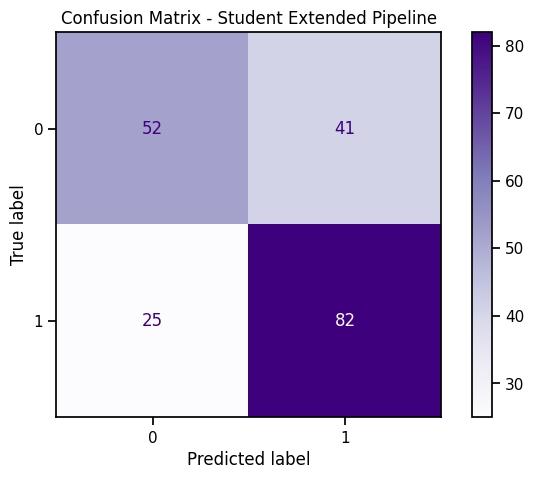

In [8]:
# TODO: Student workspace
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

# Example scaffold: add PolynomialFeatures (degree=2) to numeric pipeline
numeric_pipeline_student = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
    ]
)

preprocess_student = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_student, ["depth_m", "qc_MPa", "fs_kPa", "Rf_pct"]),
        ("cat", categorical_pipeline, ["site"]),
    ]
)

pipe_student = Pipeline(
    steps=[
        ("preprocess", preprocess_student),
        ("clf", LogisticRegression(max_iter=300)),
    ]
)

param_grid = {
    "clf__C": [0.1, 1.0, 3.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(
    pipe_student, param_grid=param_grid, cv=cv, scoring="accuracy", n_jobs=-1
)
search.fit(X, y)
print("Student: best CV score:", round(search.best_score_, 3))
print("Student: best params:", search.best_params_)

# Evaluate on a held-out test split for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Purples")
plt.title("Confusion Matrix - Student Extended Pipeline")
plt.show()

# Write your notes here:
# - What changed and why might it help